# Metrics for goodness of trees -- Local posterior probability from ASTRAL-pro and Taxonomic accuracy

In [1]:
import sys
import pandas as pd
import numpy as np
from skbio.tree import TreeNode
import matplotlib.pyplot as plt

In [2]:
import dendropy
from dendropy.calculate.treecompare import unweighted_robinson_foulds_distance, weighted_robinson_foulds_distance

In [3]:
from scipy.stats import mannwhitneyu, false_discovery_control

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

In [6]:
def get_cmap_colors(cmap_name, n):
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    return colors

## Marker genes selected with our approach

In [7]:
matrix = 'presence_absence_copies'
ks = [400]
th_simulations = [0.05, 0.1, 0.2, 0.4]
replicates = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ps = [0]
version = 2

In [8]:
trees = {}
metadata = {}
for th_simul in th_simulations:
    trees[th_simul] = {}
    metadata[th_simul] = {}
    for rep in replicates:
        dataPathIn = f'./input_data/inferred_trees/kegg/comp_th_{th_simul}/replicate_{rep}/{matrix}' 
        trees[th_simul][rep] = {}
        metadata[th_simul][rep] = {}
        for k in ks:
            for p in ps:
                metadata[th_simul][rep][p] = pd.read_table(f'{dataPathIn}/metadata_k_{k}_p_{p}_astral-pro{version}.tsv', index_col = 0)
                trees[th_simul][rep][p] = TreeNode.read(f'{dataPathIn}/nid_k_{k}_p_{p}_astral-pro{version}.nwk')

In [9]:
trees_complete = {}
metadata_complete = {}
ks = [400]
p = 0
matrix = 'presence_absence_copies'
for k in ks:
    combination = f'k_{k}_p_{p}/{matrix}' 
    dataPathIn = f'../quality_inferred_trees/input_data/emp/kegg/bit_score_threshold_1.0/no_min_marker_genes_per_genome/{combination}'
    metadata_complete[k] = pd.read_table(f'{dataPathIn}/metadata_astral-pro2.tsv', index_col = 0)
    trees_complete[k] = TreeNode.read(f'{dataPathIn}/nid_astral-pro2.nwk')

## Phylophlan

In [10]:
th_simulations = [0.05, 0.1, 0.2, 0.4]
replicates = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
version = 2

In [11]:
trees_phylophlan = {}
metadata_phylophlan = {}
for th_simul in th_simulations:
    trees_phylophlan[th_simul] = {}
    metadata_phylophlan[th_simul] = {}
    for rep in replicates:
        dataPathIn = f'./input_data/inferred_trees/phylophlan/comp_th_{th_simul}/replicate_{rep}'
        metadata_phylophlan[th_simul][rep] = pd.read_table(f'{dataPathIn}/metadata_astral-pro{version}.tsv', index_col = 0)
        trees_phylophlan[th_simul][rep] = TreeNode.read(f'{dataPathIn}/nid_astral-pro{version}.nwk')

In [12]:
dataPathIn = f'../quality_inferred_trees/input_data/emp/phylophlan/emp_min_marker_genes_per_genome_1'
phylophlan_tree_complete = TreeNode.read(f'{dataPathIn}/nid_astral-pro{version}.nwk')
phylophlan_df_complete = pd.read_table(f'{dataPathIn}/metadata_astral-pro{version}.tsv', index_col = 0)

# Figures

In [13]:
ps = [0]
th_simulations = [0.05, 0.1, 0.2, 0.4]
data = {}
for p in ps:
    data[p] = {}
    for th_simul in th_simulations:
        tmp = []
        for rep in replicates:
            datum = metadata[th_simul][rep][p]['pp1'].values
            tmp.append(np.sum(datum >= 0.95) / len(datum))
        data[p][th_simul] = np.array(tmp)

In [14]:
th_simulations = [0.05, 0.1, 0.2, 0.4]
data_phylophlan = {}
for th_simul in th_simulations:
    tmp = []
    for rep in replicates:
        datum = metadata_phylophlan[th_simul][rep]['pp1'].values
        tmp.append(np.sum(datum >= 0.95) / len(datum))
    data_phylophlan[th_simul] = np.array(tmp)

Mann-Whitney tests

In [15]:
th_simulations = [0.05, 0.1, 0.2, 0.4]
p = 0
results = []
for th in th_simulations:
    stat, p_value = mannwhitneyu(data[p][th], data_phylophlan[th])
    results.append([th, stat, p_value])

In [16]:
df_stats_lpp = pd.DataFrame(results, columns = ['incompleteness_threshold', 'statistic', 'p-value'])
df_stats_lpp.set_index('incompleteness_threshold', inplace = True)

Benjamini-Hochberg correction for multiple testing

In [17]:
df_stats_lpp['q-value'] = false_discovery_control(df_stats_lpp['p-value'].values)

In [18]:
df_stats_lpp

,statistic,p-value,q-value
incompleteness_threshold,,,
0.05,100.0,0.000179,0.000181
0.10,100.0,0.000181,0.000181
0.20,100.0,0.000181,0.000181
0.40,100.0,0.000179,0.000181


In [19]:
def sig_sign(p_value):
    if p_value > 0.05:
        return 'ns'
    elif p_value > 0.01:
        return '*'
    elif p_value > 0.001:
        return '**'
    elif p_value > 0.0001:
        return '***'
    else:
        return '****'

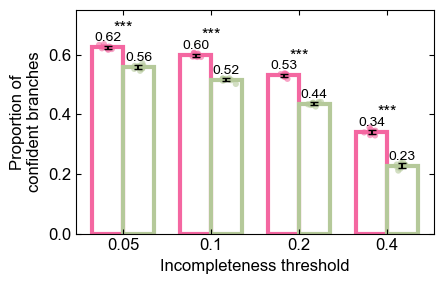

In [20]:
plt.figure(figsize=(4.6, 3))

# X locations for bars
p = 0
x = np.array([0, 1, 2, 3])  
width = 0.35  # Width of the bars
rng = np.random.default_rng(42)

# Means and standard deviations
means_data = [data[p][0.05].mean(), data[p][0.1].mean(), data[p][0.2].mean(), data[p][0.4].mean()]
stds_data = [data[p][0.05].std(), data[p][0.1].std(), data[p][0.2].std(), data[p][0.4].std()]

means_phylophlan = [data_phylophlan[0.05].mean(), data_phylophlan[0.1].mean(), 
                     data_phylophlan[0.2].mean(), data_phylophlan[0.4].mean()]
stds_phylophlan = [data_phylophlan[0.05].std(), data_phylophlan[0.1].std(),
                    data_phylophlan[0.2].std(), data_phylophlan[0.4].std()]

# Plot bars
plt.bar(x - width/2, means_data, width, yerr = stds_data, capsize = 3,
        edgecolor = '#f467a1', alpha = 1.0, color = 'none', lw = 3)
plt.bar(x + width/2, means_phylophlan, width, yerr = stds_phylophlan, capsize = 3,
        edgecolor = '#b5c99a', alpha = 1.0, color = 'none', lw = 3)
# Add individual data points as scatter overlaid on top of bars
for i in range(len(x)):
        plt.scatter(np.full(len(data[p][th_simulations[i]]), x[i] - width/2 + rng.normal(0, 0.05, 
                len(data[p][th_simulations[i]]))), data[p][th_simulations[i]],
                color = '#f467a1', alpha = 0.6, s = 20, edgecolor = 'none')
        plt.scatter(np.full(len(data_phylophlan[th_simulations[i]]), x[i] + width/2 + rng.normal(0, 0.05, 
                len(data_phylophlan[th_simulations[i]]))), data_phylophlan[th_simulations[i]], 
                color = '#b5c99a', alpha = 0.6, s = 20, edgecolor = 'none')

# Add annotations
for i in range(len(x)):
        plt.text(x[i] - width/2, means_data[i] + 0.02, 
                 f'{means_data[i]:.2f}', 
                 ha = 'center', fontsize = 10)
        plt.text(x[i] + width/2, means_phylophlan[i] + 0.02, 
                 f'{means_phylophlan[i]:.2f}', 
                 ha = 'center', fontsize = 10)

# Add q-values
for i in range(len(x)):
    plt.text(x[i], max(means_data[i], means_phylophlan[i]) + 0.05,
             f'{sig_sign(df_stats_lpp.loc[th_simulations[i]]["q-value"])}', 
             ha = 'center', fontsize = 12, color = 'black')

# X-axis labels and formatting
plt.xticks(x, labels = [0.05, 0.1, 0.2, 0.4])
plt.ylabel('Proportion of\nconfident branches')
plt.xlabel('Incompleteness threshold')
plt.tick_params(top=True, right=True, direction='in', which='both')
plt.ylim(0, 0.75)

# Save and show
plt.savefig('./figures/lpp_completeness_barplot.svg')
plt.show()

### Robinson-Foulds distance --DendroPy

In [34]:
def shared_taxa(tree1, tree2):
    taxa1 = {node.taxon.label for node in tree1.leaf_node_iter()}
    taxa2 = {node.taxon.label for node in tree2.leaf_node_iter()}
    return list(taxa1.intersection(taxa2)), taxa1, taxa2

In [35]:
def RF_distance(treeA, treeB, norm = True, **kwargs):
    
    treeA_copy, treeB_copy = dendropy.Tree(treeA), dendropy.Tree(treeB)
    
    # Prune trees such that they contain the same taxa, otherwise RF is much larger
    taxa_to_keep, taxa1, taxa2 = shared_taxa(treeA_copy, treeB_copy)
    if len(taxa_to_keep) < len(taxa1) or len(taxa_to_keep) < len(taxa2):
        treeA_copy.retain_taxa_with_labels(taxa_to_keep)
        treeB_copy.retain_taxa_with_labels(taxa_to_keep)
        
    # Update bipartition
    treeA_copy.update_bipartitions()
    treeB_copy.update_bipartitions()
    
    # Assuming trees share the same taxon name space
    rf = unweighted_robinson_foulds_distance(treeA_copy, treeB_copy)
    if norm:
        # Normalize by the maximal possible distance: which is the sum of internal branches
        # between both trees. Alternatively, if both trees are unrooted and binary, the sum
        # is always 2n - 6, where n is the number of tips in the tree.
        max_dist = 2 * len(taxa_to_keep) - 6
        # Number of internal branches
        # n, m = num_internal_branches(treeA_copy), num_internal_branches(treeB_copy)
        if len(taxa_to_keep) > 3:
            rf = rf / max_dist
        else:
            rf = 0.0

    # Ratio between species in inferred to actual species tree
    ratio_sps = len(taxa2) / len(taxa1)
    # print(f'Ratios of sps: {ratio_sps}')
    
    return rf

In [36]:
taxon_namespace = dendropy.TaxonNamespace()

Marker genes selected with our approach

In [37]:
matrix = 'presence_absence_copies'
ks = [400]
th_simulations = [0.05, 0.1, 0.2, 0.4]
replicates = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ps = [-10, -5, -2, -1, 0]
version = 2

In [38]:
trees_dendro = {}
for th_simul in th_simulations:
    trees_dendro[th_simul] = {}
    for rep in replicates:
        dataPathIn = f'./input_data/inferred_trees/kegg/comp_th_{th_simul}/replicate_{rep}/{matrix}' 
        trees_dendro[th_simul][rep] = {}
        for k in ks:
            for p in ps:
                trees_dendro[th_simul][rep][p] = dendropy.Tree.get(path = f'{dataPathIn}/nid_k_{k}_p_{p}_astral-pro{version}.nwk',
                                schema = 'newick', taxon_namespace = taxon_namespace)

In [39]:
trees_complete_dendro = {}
ks = [400, 600, 800, 1000]
p = 0
matrix = 'presence_absence_copies'
for k in ks:
    combination = f'k_{k}_p_{p}/{matrix}'
    dataPathIn = f'../quality_inferred_trees/input_data/emp/kegg/bit_score_threshold_1.0/no_min_marker_genes_per_genome/{combination}'
    trees_complete_dendro[k] = dendropy.Tree.get(path = f'{dataPathIn}/nid_astral-pro2.nwk',
                                schema = 'newick', taxon_namespace = taxon_namespace)

Phylophlan

In [40]:
th_simulations = [0.05, 0.1, 0.2, 0.4]
replicates = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
version = 2

In [41]:
trees_phylophlan_dendro = {}
for th_simul in th_simulations:
    trees_phylophlan_dendro[th_simul] = {}
    for rep in replicates:
        dataPathIn = f'./input_data/inferred_trees/phylophlan/comp_th_{th_simul}/replicate_{rep}'
        trees_phylophlan_dendro[th_simul][rep] = dendropy.Tree.get(path = f'{dataPathIn}/nid_astral-pro{version}.nwk',
                                schema = 'newick', taxon_namespace = taxon_namespace)

In [42]:
dataPathIn = f'../quality_inferred_trees/input_data/emp/phylophlan/emp_min_marker_genes_per_genome_1'
phylophlan_tree_complete_dendro = dendropy.Tree.get(path = f'{dataPathIn}/nid_astral-pro{version}.nwk',
                                schema = 'newick', taxon_namespace = taxon_namespace)

In [43]:
ps = [0]
th_simulations = [0.05, 0.1, 0.2, 0.4]
data_dendro = {}
for p in ps:
    data_dendro[p] = {}
    for th_simul in th_simulations:
        tmp = []
        for rep in replicates:
            tmp.append(RF_distance(trees_dendro[th_simul][rep][p], trees_complete_dendro[400]))
        data_dendro[p][th_simul] = np.array(tmp)

In [44]:
th_simulations = [0.05, 0.1, 0.2, 0.4]
data_phylophlan_dendro = {}
for th_simul in th_simulations:
    tmp = []
    for rep in replicates:
        tmp.append(RF_distance(trees_phylophlan_dendro[th_simul][rep], phylophlan_tree_complete_dendro))
    data_phylophlan_dendro[th_simul] = np.array(tmp)

Mann-Whitney tests

In [45]:
th_simulations = [0.05, 0.1, 0.2, 0.4]
p = 0
results = []
for th in th_simulations:
    stat, p_value = mannwhitneyu(data_dendro[p][th], data_phylophlan_dendro[th])
    results.append([th, stat, p_value])

In [46]:
df_stats_rf = pd.DataFrame(results, columns = ['incompleteness_threshold', 'statistic', 'p-value'])
df_stats_rf.set_index('incompleteness_threshold', inplace = True)

Benjamini-Hochberg correction for multiple testing

In [47]:
df_stats_rf['q-value'] = false_discovery_control(df_stats_rf['p-value'].values)

In [48]:
df_stats_rf

,statistic,p-value,q-value
incompleteness_threshold,,,
0.05,24.0,0.053722,0.053722
0.10,11.0,0.003548,0.004730
0.20,0.0,0.000181,0.000363
0.40,0.0,0.000182,0.000363


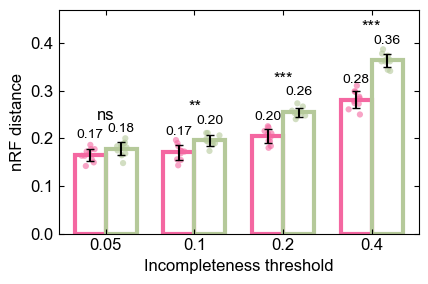

In [49]:
plt.figure(figsize=(4.45, 3))

# X locations for bars
p = 0
x = np.array([0, 1, 2, 3])  
width = 0.35  # Width of the bars
rng = np.random.default_rng(42)

# Means and standard deviations
means_data = [data_dendro[p][0.05].mean(), data_dendro[p][0.1].mean(), data_dendro[p][0.2].mean(), data_dendro[p][0.4].mean()]
stds_data = [data_dendro[p][0.05].std(), data_dendro[p][0.1].std(), data_dendro[p][0.2].std(), data_dendro[p][0.4].std()]

means_phylophlan = [data_phylophlan_dendro[0.05].mean(), data_phylophlan_dendro[0.1].mean(), 
                     data_phylophlan_dendro[0.2].mean(), data_phylophlan_dendro[0.4].mean()]
stds_phylophlan = [data_phylophlan_dendro[0.05].std(), data_phylophlan_dendro[0.1].std(),
                    data_phylophlan_dendro[0.2].std(), data_phylophlan_dendro[0.4].std()]

# Plot bars
plt.bar(x - width/2, means_data, width, yerr = stds_data, capsize = 3,
        edgecolor = '#f467a1', alpha = 1.0, color = 'none', lw = 3)
plt.bar(x + width/2, means_phylophlan, width, yerr = stds_phylophlan, capsize = 3,
        edgecolor = '#b5c99a', alpha = 1.0, color = 'none', lw = 3)
# Add individual data points as scatter overlaid on top of bars
for i in range(len(x)):
        plt.scatter(np.full(len(data_dendro[p][th_simulations[i]]), x[i] - width/2 + rng.normal(0, 0.05, 
                len(data_dendro[p][th_simulations[i]]))), data_dendro[p][th_simulations[i]],
                color = '#f467a1', alpha = 0.6, s = 20, edgecolor = 'none')
        plt.scatter(np.full(len(data_phylophlan_dendro[th_simulations[i]]), x[i] + width/2 + rng.normal(0, 0.05, 
                len(data_phylophlan_dendro[th_simulations[i]]))), data_phylophlan_dendro[th_simulations[i]], 
                color = '#b5c99a', alpha = 0.6, s = 20, edgecolor = 'none')


# Add annotations
for i in range(len(x)):
        plt.text(x[i] - width/2, means_data[i] + 0.035, 
                 f'{means_data[i]:.2f}', 
                 ha = 'center', fontsize = 10)
        plt.text(x[i] + width/2, means_phylophlan[i] + 0.035, 
                 f'{means_phylophlan[i]:.2f}', 
                 ha = 'center', fontsize = 10)

# Add q-values
for i in range(len(x)):
    plt.text(x[i], max(means_data[i], means_phylophlan[i]) + 0.07,
             f'{sig_sign(df_stats_rf.loc[th_simulations[i]]["q-value"])}', 
             ha = 'center', va = 'center', fontsize = 12, color = 'black')

# X-axis labels and formatting
plt.xticks([0, 1, 2, 3], labels = [0.05, 0.1, 0.2, 0.4])
plt.ylabel('nRF distance')
plt.xlabel('Incompleteness threshold')
plt.tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.ylim(0, 0.47)

# Save and show
plt.savefig(f'./figures/figure_4C.svg')
plt.show()